
### 1. Problem Undestanding
Here we will look at a Data Science challenge within the IMDB space. For our model fitting choose the f1-score metric.

### Import libraries & data 

In [1]:
import matplotlib.pyplot as plt

# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS
from sklearn.metrics import f1_score

import re

from textblob import TextBlob



In [2]:
#definition constants
RANDOM_STATE = 11
MAX_ITER=4000
NUMBER_K_FOLD = 5
TARGET_METRIC = 'f1'

In [3]:
#Results of exploring for model we will provided in table model_search_result
model_search_result = pd.DataFrame(columns=['Model',
                                            'Preprocessing',
                                            'Vectorizer',
                                            'Vectorizer_description',
                                            'F1 train',
                                            'F1 test', ], )
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test


In [4]:
# import & display data
data = pd.read_csv('data/IMDB_Dataset.csv')

### The Data
Our training set has 50K movie reviews for natural language processing.  This is a dataser for binary sentiment classification. 
For more dataset information, please go through the following link,
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check statistics

In [6]:
data.count()

review       50000
sentiment    50000
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


The Dataset contains invalid non-unique values. In the next step research we should drop all data repetitions

In [9]:
data[data.duplicated()].head()

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative


#### replace the categoric values from 'sentiment' to numeric

In [10]:
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})

In [11]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### 2. Splitting data for train and test sets

In [12]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify = y)

In [13]:
print('Size of train set: ' + str(X_train.size) +
     '\nShare of positive samples in train set: ' + str(y_train[y_train==1].count()/y_train.size))
print('Size of test set: ' + str(X_test.size) +
     '\nShare of positive samples in test set: ' + str(y_test[y_test==1].count()/y_test.size))

Size of train set: 35000
Share of positive samples in train set: 0.5
Size of test set: 15000
Share of positive samples in test set: 0.5


#### Applying CountVectorizer for convert a collection of text documents to a matrix of token counts

In [14]:
# Instantiate the vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [15]:
# fit and transform on it the training features
count_vectorizer.fit(X_train)
X_train_features = count_vectorizer.transform(X_train)

#transform the test features to sparse matrix
X_test_features = count_vectorizer.transform(X_test)


#### Resulting the vocabulary dictionary 

In [16]:
list(count_vectorizer.vocabulary_.keys())[:20]

['strangely',
 'enjoyable',
 'effort',
 'combining',
 'an',
 'appropriately',
 'far',
 'fetched',
 'plot',
 'involving',
 'adam',
 'and',
 'burt',
 'flashbacks',
 'to',
 'the',
 'original',
 'tv',
 'series',
 'most']

### 3. Classify

In [74]:


# definition common function

# add data to result table
def add_model_to_result_table(resultTable, model, preprocessing, vectorizer, vectorizer_description, f1_train, f1_test):
    modelItem = [model,
                 preprocessing, 
                 vectorizer,    
                 vectorizer_description,
                 f1_train, 
                 f1_test]
    if any([str(modelItem) == str(list(row[1][:])) for row in resultTable.iterrows()]):
        return(resultTable)
    resultTable.loc[resultTable.shape[0] + 1] = modelItem
    return(resultTable)
    
# plot F1-score
def plot_f1_curve(result_table):
    
    plt.title("A F1 score curve")
    labeles = ['F1 train', 'F1 test']
    for l in labeles:
        plt.plot(result_table.index, result_table[l], label =l)
    plt.xlabel("Index the model from the result  table")
    plt.ylabel("f1")
    plt.legend()


    

### Grid search cross validation


In [18]:
hyperparams_log_reg = {
    'C': np.logspace(-2, 2, 15), 
}

logreg_model_cross_valid=LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)
logreg_cv = GridSearchCV(logreg_model_cross_valid, 
                         hyperparams_log_reg, scoring =TARGET_METRIC, 
                         cv=NUMBER_K_FOLD, 
                         return_train_score=True )

logreg_cv.fit(X_train_features, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=4000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=11, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 1.93069773e-02, 3.72759372e-02, 7.19685673e-02,
       1.38949549e-01, 2.68269580e-01, 5.17947468e-01, 1.00000000e+00,
       1.93069773e+00, 3.72759372e+00, 7.19685673e+00, 1.38949549e+01,
       2.68269580e+01, 5.17947468e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, re

#### Results Cross Validation

##### The best value F1 score for cross validation

In [19]:
logreg_cv.best_score_

0.8914672009081602

##### The best estimator for cross validation

In [20]:
logreg_cv.best_estimator_

LogisticRegression(C=0.07196856730011521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Result of Cross validation with 5 folds

In [21]:

result_cv = pd.DataFrame(columns = ['C_param', 'F1-score'], index = range(0,5))
for splitN in range(5):
    result_cv['F1-score'][splitN] = logreg_cv.cv_results_['split'+str(splitN)+'_test_score'].max()
    result_cv['C_param'][splitN] = logreg_cv.cv_results_['params'][np.argmax(logreg_cv.cv_results_['split'+str(splitN)+'_test_score'])]["C"]
result_cv

,C_param,F1-score
0,0.0372759,0.892898
1,0.0719686,0.890122
2,0.0372759,0.897342
3,0.0719686,0.891403
4,0.0719686,0.887065


### Choose the model after CV


In [22]:
baseline_model=LogisticRegression(C=logreg_cv.best_estimator_.C, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=RANDOM_STATE, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
baseline_model.fit(X_train_features, y_train)

LogisticRegression(C=0.07196856730011521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Add model to the result table

In [24]:
model_search_result = add_model_to_result_table(model_search_result, 
                                                baseline_model, 
                                                'None-basemodel', 
                                                count_vectorizer,
                                                'None-basemodel',
                                               f1_score(y_train, baseline_model.predict(X_train_features)),
                                               f1_score(y_test, baseline_model.predict(X_test_features)))
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145


### 4. Explore 

In [25]:
#fuction for find out the samples with particular text
def find_out_samples_with_text(data_for_explore, template):
    return [review for review in data_for_explore['review'] if  template in review.lower()]


### Prepocessing
#### The first step for preprocessing is remove html tags

In [26]:
preprocessing1 = 'Remove htmg tags'

In [27]:
def cleanhtml(raw_html):
    cleantext = re.sub(r'<br.*?>', ' ', raw_html)
    return cleantext
#   cleanr = re.compile('(<br >)|(<br />)|(\b[Bb][Rr]\b)|( [Bb][Rr] )')

In [28]:
data_prepoc_remove_tags = data.copy()
data_prepoc_remove_tags['review'] = data_prepoc_remove_tags.apply(lambda x: cleanhtml(x['review']), axis = 1)

In [30]:
def model_exploring(data_explor, preprocessing_explor, count_vectorizer_explor, count_vectorizer_description_explor):
    #split data for train and test sets
    X_explor = data_explor['review']
    y_explor = data_explor['sentiment']
    X_train_explor, X_test_explor, y_train_explor, y_test_explor = train_test_split(X_explor, y_explor, 
                                                                                        test_size=0.3, 
                                                                                        random_state=RANDOM_STATE, 
                                                                                        stratify = y_explor)
  
    
    
    # fit and transform on it the training features
    count_vectorizer_explor.fit(X_train_explor)
    X_train_features_explor = count_vectorizer_explor.transform(X_train_explor)
    
    #transform the test features to sparse matrix
    X_test_features_explor = count_vectorizer_explor.transform(X_test_explor)
    
    model_explor = LogisticRegression(C=logreg_cv.best_estimator_.C, class_weight=None, 
                                                  dual=False, fit_intercept=True, intercept_scaling=1, 
                                                  l1_ratio=None, max_iter=4000, multi_class='auto', 
                                                  n_jobs=None, penalty='l2', random_state=RANDOM_STATE, 
                                                  solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
    model_explor.fit(X_train_features_explor, y_train_explor)
    
    return(add_model_to_result_table(model_search_result, 
                                     model_explor, 
                                     preprocessing_explor, 
                                     count_vectorizer_explor,
                                     count_vectorizer_description_explor,
                                     f1_score(y_train_explor, model_explor.predict(X_train_features_explor)),
                                     f1_score(y_test_explor, model_explor.predict(X_test_features_explor)),
                                    ))


In [31]:
# fit the baseline model with for data after preprocessing
model_search_result = model_exploring(data_prepoc_remove_tags, preprocessing1, CountVectorizer(), 'None')
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945


In [32]:
# compare vocabularies
sorted(list(set(model_search_result['Vectorizer'][model_search_result['Preprocessing']=='None-basemodel'].iloc[0]
                .get_feature_names())
            .symmetric_difference(set(model_search_result['Vectorizer'][model_search_result['Preprocessing']=='Remove htmg tags'].iloc[0]
                                      .get_feature_names()))))

[]

#### The second step for preprocessing is remove duplicates ans incorrect data

In [33]:
preprocessing2 = 'Remove duplicates'

In [34]:
data_prepoc_remove_duplicates = data.copy()

In [35]:
data_prepoc_remove_duplicates[data_prepoc_remove_duplicates.duplicated()].describe(include='object')

,review
count,418
unique,406
top,Loved today's show!!! It was a variety and not...
freq,4


In [36]:
# drop all duplicates rows, (indexes are ignored.)
data_prepoc_remove_duplicates = data_prepoc_remove_duplicates.drop_duplicates()

In [37]:
# check if we have only unique value of Review
data_prepoc_remove_duplicates.describe(include='object')

,review
count,49582
unique,49582
top,CyberTracker is set in Los Angeles sometime in...
freq,1


In [38]:
# fit the baseline model with for data after preprocessing
model_search_result = model_exploring(data_prepoc_remove_duplicates, preprocessing2, CountVectorizer(), 'None')
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400


#### The third step for preprocessing is remove digits from data

In [39]:
preprocessing3_1 = 'Remove all digits'

In [40]:
#check vocabulary from baseline 
print('Baseline vocabulary contains ' +
      str(len([feature_name for feature_name in count_vectorizer.get_feature_names() if re.match(r'.*\d.*', feature_name)])) +
     ' features with digits')


Baseline vocabulary contains 1566 features with digits


In [41]:
# firstly try removing all digits
def clean_all_digit(text):
    cleantext = re.sub(r'\d+', ' ', text)
    return cleantext

In [43]:
#prepare data 
data_prepoc_remove_all_digits = data.copy()
data_prepoc_remove_all_digits['review'] = data_prepoc_remove_all_digits.apply(lambda x: clean_all_digit(x['review']), axis = 1)
data_prepoc_remove_all_digits.head(5)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [44]:

model_search_result = model_exploring(data_prepoc_remove_all_digits, preprocessing3_1, CountVectorizer(), 'None') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965


In [46]:
# compare vocabularies
print('The baseline vocabulary contains ' + 
      str(len(model_search_result['Vectorizer'][model_search_result['Preprocessing']=='None-basemodel'].iloc[0]
                .get_feature_names())) + 
     ' features')
print('The vocabulary after remove all digits contains ' + 
      str(len(model_search_result['Vectorizer'][model_search_result['Preprocessing']=='Remove all digits'].iloc[0]
                .get_feature_names())) + 
     ' features')
  

The baseline vocabulary contains 88087 features
The vocabulary after remove all digits contains 86621 features


In [47]:
#secondly try splitting digits and letters
preprocessing3_2 = 'Split digits with letters'

def split_digit_letter(text):
    cleantext = re.sub(r'(\d+)', r' \1 ', text)
    cleantext = re.sub(r'_+', r' ', cleantext)
    return cleantext

In [48]:
#prepare data 
data_prepoc_split_digit_letter = data.copy()
data_prepoc_split_digit_letter['review'] = data_prepoc_split_digit_letter.apply(lambda x: split_digit_letter(x['review']), axis = 1)
data_prepoc_split_digit_letter.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [49]:
model_search_result = model_exploring(data_prepoc_split_digit_letter, preprocessing3_2, CountVectorizer(), 'None') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159


#### The fourth step for preprocessing is replace words with the one form


In [50]:
preprocessing4_1 = 'Replace with correct form'

def replace_word_with_correct_form(text):
    cleantext = re.sub(r'(a+r+g+h+)', 'argh', text)
    cleantext = re.sub(r'(a+h+g+)', 'ahg', cleantext)
    cleantext = re.sub(r'(a+h+)', 'ah', cleantext)
    cleantext = re.sub(r'(\ba{2,})', 'a', cleantext)
    return cleantext

In [51]:
# prepare data 
data_replace_word_with_correct_form = data.copy()
data_replace_word_with_correct_form['review'] = data_replace_word_with_correct_form.apply(lambda x: replace_word_with_correct_form(x['review']), axis = 1)


In [52]:
model_search_result = model_exploring(data_replace_word_with_correct_form, preprocessing4_1, CountVectorizer(), 'None') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085


### Vectorization
#### The first step for vectorization is using n_gramm

In [53]:
model_search_result = model_exploring(data, 'None', CountVectorizer(ngram_range=(1,3)), 'ngram_range=(1,3)') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006


In [54]:
model_search_result = model_exploring(data, 'None', CountVectorizer(ngram_range=(1,2)), 'ngram_range=(1,2)') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564


In [61]:
model_search_result = model_exploring(data, 'None', CountVectorizer(ngram_range=(2,2)), 'ngram_range=(2,2)') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564
9,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(2,2)",0.998515,0.891359


#### The second step for vectorization is using the list Stop Words

In [62]:
model_search_result = model_exploring(data, 'None', CountVectorizer(stop_words='english'), 'stop_words=english') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564
9,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(2,2)",0.998515,0.891359
10,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...",stop_words=english,0.962234,0.891504


In [63]:
# model_search_result = model_search_result.drop([9,11,12,13,14], axis=0)
# model_search_result

#### The third step for vectorization is limitation size of the vocabulary 


In [64]:
model_search_result = model_exploring(data, 'None', CountVectorizer(max_features=50000), 'max_features=50000') 
model_search_result = model_exploring(data, 'None', CountVectorizer(max_features=75000), 'max_features=75000') 
model_search_result = model_exploring(data, 'None', CountVectorizer(max_features=80000), 'max_features=80000') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564
9,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(2,2)",0.998515,0.891359
10,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...",stop_words=english,0.962234,0.891504


#### The fourth step is min_df and max_df

In [65]:

model_search_result = model_exploring(data, 'None', CountVectorizer(min_df=50), 'min_df=50')
model_search_result = model_exploring(data, 'None', CountVectorizer(min_df=200), 'min_df=200')
model_search_result = model_exploring(data, 'None', CountVectorizer(max_df=0.99), 'max_df=0.99')
model_search_result = model_exploring(data, 'None', CountVectorizer(max_df=0.9999), 'max_df=0.9999')
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564
9,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(2,2)",0.998515,0.891359
10,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...",stop_words=english,0.962234,0.891504


### TfIdfVectorizer

Apply TfidfVectorizer with parameters:
smooth_idfbool = False, in our set the situation when an extra document was seen containing every term in the collection exactly once is unlikely.
sublinear_tf=True, replace tf with 1 + log(tf).(this parameter might be used for gridSearch)
norm=None, 

In [66]:
model_search_result = model_exploring(data_prepoc_split_digit_letter,
                                      preprocessing3_2, 
                                      TfidfVectorizer(ngram_range=(1,2), smooth_idf=False, sublinear_tf=True, norm=None, ), 
                                      'TfidfVectorizer, ngram_range=(1,2)\n smooth_idf=False, sublinear_tf=True, norm=None,') 
model_search_result

,Model,Preprocessing,Vectorizer,Vectorizer_description,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None-basemodel,"CountVectorizer(analyzer='word', binary=False,...",None-basemodel,0.965712,0.899145
2,"LogisticRegression(C=0.07196856730011521, clas...",Remove htmg tags,"CountVectorizer(analyzer='word', binary=False,...",None,0.965600,0.898945
3,"LogisticRegression(C=0.07196856730011521, clas...",Remove duplicates,"CountVectorizer(analyzer='word', binary=False,...",None,0.965288,0.894400
4,"LogisticRegression(C=0.07196856730011521, clas...",Remove all digits,"CountVectorizer(analyzer='word', binary=False,...",None,0.964779,0.898965
5,"LogisticRegression(C=0.07196856730011521, clas...",Split digits with letters,"CountVectorizer(analyzer='word', binary=False,...",None,0.965566,0.899159
6,"LogisticRegression(C=0.07196856730011521, clas...",Replace with correct form,"CountVectorizer(analyzer='word', binary=False,...",None,0.965682,0.899085
7,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,3)",0.999829,0.909006
8,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(1,2)",0.998772,0.909564
9,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...","ngram_range=(2,2)",0.998515,0.891359
10,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...",stop_words=english,0.962234,0.891504


#### Apply the preprocessing steps and the best vectorizer  for the dataset

In [70]:
#clean data
data_cleaned = data.copy()
data_cleaned = data_cleaned.drop_duplicates()
data_cleaned['review'] = data_cleaned['review'].apply(lambda x: cleanhtml(split_digit_letter(x)))
data_cleaned.head(5)

X_cleaned = data_cleaned['review']
y_cleaned = data_cleaned['sentiment']
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned,
                                                                                    y_cleaned,
                                                                                    test_size=0.3,
                                                                                    random_state=RANDOM_STATE,
                                                                                    stratify = y_cleaned)
  
    
    
# fit and transform on it the training features
tf_idf_vectorizer_cleaned = TfidfVectorizer(smooth_idf=False, sublinear_tf=True, norm=None, ngram_range=(1,2))
tf_idf_vectorizer_cleaned.fit(X_train_cleaned)

X_train_features_tf_idf_cleaned = tf_idf_vectorizer_cleaned.transform(X_train_cleaned)
    
#transform the test features to sparse matrix
X_test_features_tf_idf_cleaned = tf_idf_vectorizer_cleaned.transform(X_test_cleaned)
    
model_tf_idf_cleaned = LogisticRegression(C=logreg_cv.best_estimator_.C, class_weight=None, 
                                                  dual=False, fit_intercept=True, intercept_scaling=1, 
                                                  l1_ratio=None, max_iter=4000, multi_class='auto', 
                                                  n_jobs=None, penalty='l2', random_state=RANDOM_STATE, 
                                                  solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
model_tf_idf_cleaned.fit(X_train_features_tf_idf_cleaned, y_train_cleaned)
print('f1 score for training set ' + str(f1_score(y_train_cleaned, model_tf_idf_cleaned.predict(X_train_features_tf_idf_cleaned))))
print('f1 score for testing set ' + str(f1_score(y_test_cleaned, model_tf_idf_cleaned.predict(X_test_features_tf_idf_cleaned))))

f1 score for training set 1.0
f1 score for testing set 0.9103484969406758


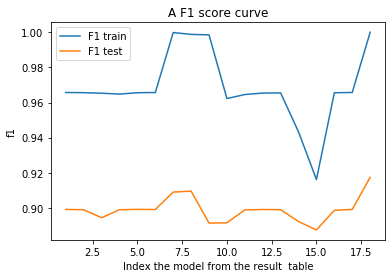

In [75]:
plot_f1_curve(model_search_result)